# Model Arima for Time Series Forecasting temperature

## LLibreries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [70]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(os.getcwd(), carpeta_dades, fitxer_dades)


    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head(10)


,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
5,1998-01-01 05:00:00+00:00,-6.00
6,1998-01-01 06:00:00+00:00,-6.00
7,1998-01-01 07:00:00+00:00,-6.00
8,1998-01-01 08:00:00+00:00,-5.60
9,1998-01-01 09:00:00+00:00,-4.60


In [65]:
# Intentem unificar les dades en promig de cada 6 hores.
# Es a dir, fem un dataframe on les dades que afegirem sera el promig del valor cada 6 hores. Per tant serà una entrada a les 6h, 12h, 18h i 24h.
# Respectant els horaris de les dades originals seria, per cada dia, interval de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59.

# Convertim la columna 'data' a datetime si no ho està
df['data'] = pd.to_datetime(df['data'])

# Assignem cada registre al seu interval corresponent de 6 hores
# Els intervals seran: 00:00-05:59, 06:00-11:59, 12:00-17:59 i 18:00-23:59
df['interval_6h'] = df['data'].dt.floor('6H')

# Creem un nou dataframe agrupant les dades per intervals de 6 hores i calculant el promig
df_agrupades = df.groupby('interval_6h', as_index=False)['valor'].mean()

# Canviem el nom de la columna de data per mantenir la coherència
df_agrupades.rename(columns={'interval_6h': 'data'}, inplace=True)

# Ordenem el dataframe per data
df_agrupades = df_agrupades.sort_values(by='data').reset_index(drop=True)

# Mostrem les primeres files per verificar el resultat
df_agrupades.head(10)

/tmp/ipykernel_6023/2519749339.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['interval_6h'] = df['data'].dt.floor('6H')


,data,valor
0,1998-01-01 00:00:00+00:00,-5.383333
1,1998-01-01 06:00:00+00:00,-4.733333
2,1998-01-01 12:00:00+00:00,-1.983333
3,1998-01-01 18:00:00+00:00,-1.800000
4,1998-01-02 00:00:00+00:00,-2.066667
5,1998-01-02 06:00:00+00:00,1.016667
6,1998-01-02 12:00:00+00:00,-1.616667
7,1998-01-02 18:00:00+00:00,-3.533333
8,1998-01-03 00:00:00+00:00,-2.183333
9,1998-01-03 06:00:00+00:00,2.150000


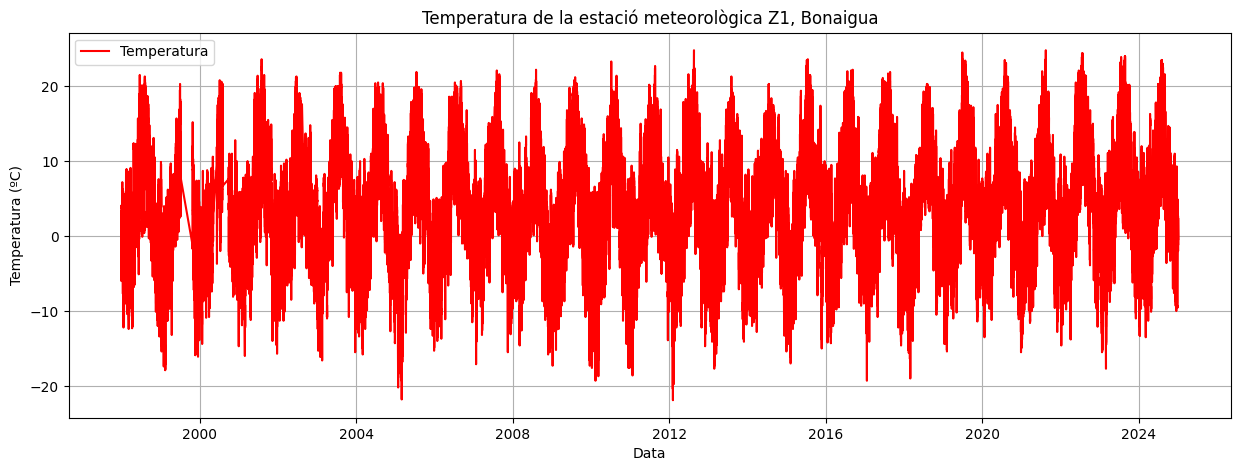

In [66]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


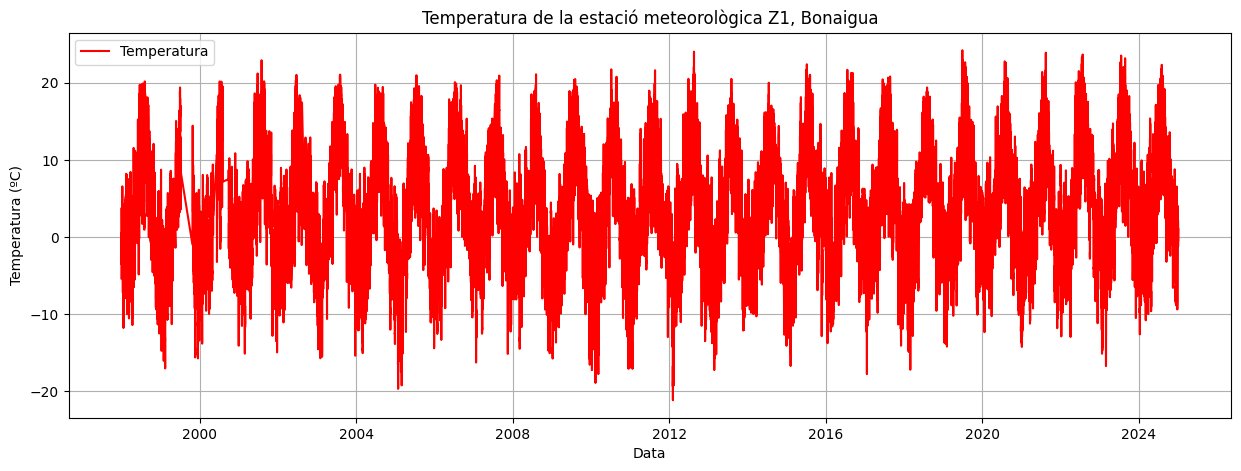

In [67]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df_agrupades['data'], df_agrupades['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Construcció model ARIMA

In [75]:
data = df_agrupades.copy()

In [82]:
data.set_index('data', inplace=True)
data.head(10)


,valor
data,
1998-01-01 00:00:00+00:00,-5.38
1998-01-01 06:00:00+00:00,-4.73
1998-01-01 12:00:00+00:00,-1.98
1998-01-01 18:00:00+00:00,-1.80
1998-01-02 00:00:00+00:00,-2.07
1998-01-02 06:00:00+00:00,1.02
1998-01-02 12:00:00+00:00,-1.62
1998-01-02 18:00:00+00:00,-3.53
1998-01-03 00:00:00+00:00,-2.18


In [118]:
# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA


# Definim els paràmetres p, d i q
p = 2  # Ordre de l'auto-regressió
d = 1  # Ordre de la diferenciació
q = 2  # Ordre de la mitjana mòbil

# Creem el model ARIMA
model = ARIMA(data['valor'], order=(p, d, q))

# Ajustem el model
model = model.fit()

# Mostrem el resum del model ajustat
print(model.summary())


/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                38373
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -74248.680
Date:                Thu, 03 Apr 2025   AIC                         148507.360
Time:                        14:14:53   BIC                         148550.135
Sample:                             0   HQIC                        148520.926
                              - 38373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0003      0.000     -0.875      0.382      -0.001       0.000
ar.L2         -0.9974      0.000  -2897.449      0.000      -0.998      -0.997
ma.L1          0.0078      0.002      4.150      0.0

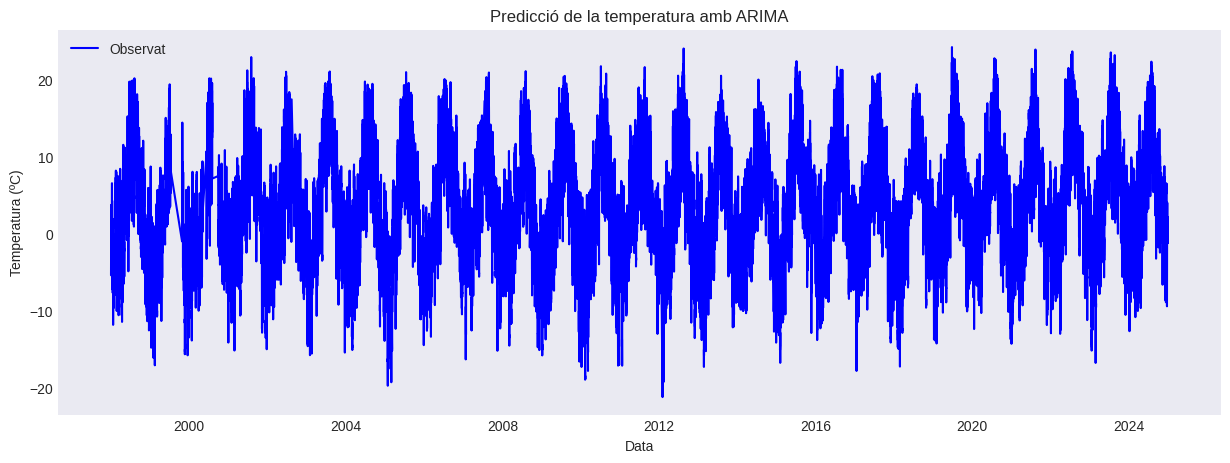

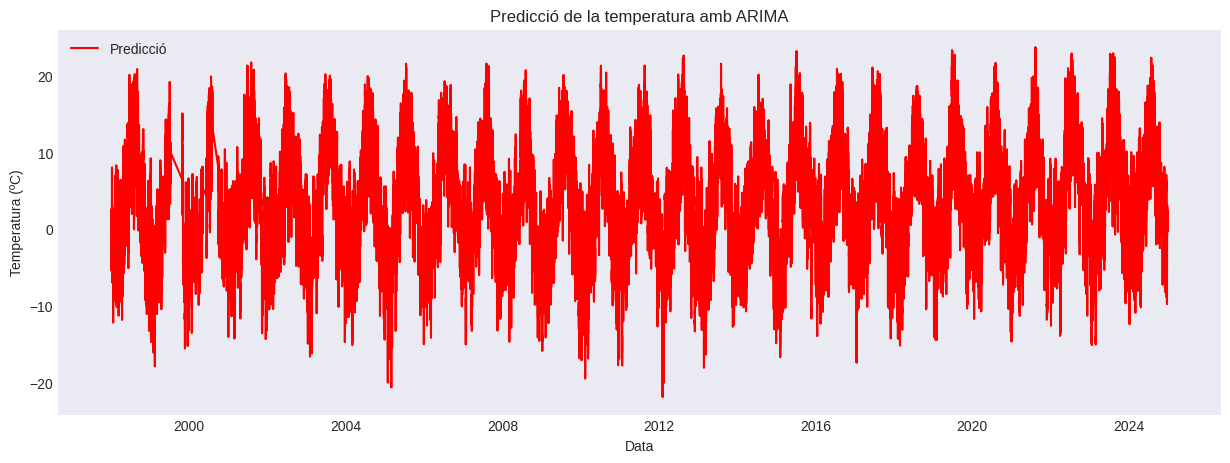

In [119]:
# Predicció de tota la serie temporal

# Realitzem la predicció
predictions = model.get_prediction(start=data.index[0], end=data.index[-1], dynamic=False)

# Obtenim els valors predits i els intervals de confiança

predicted_mean = predictions.predicted_mean
predicted_ci = predictions.conf_int()
# Plotem els resultats
plt.figure(figsize=(15, 5))
plt.plot(data['valor'], label='Observat', color='blue')
# plt.plot(predicted_mean, label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Plot predicció

plt.figure(figsize=(15, 5))
plt.plot(predicted_mean, label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


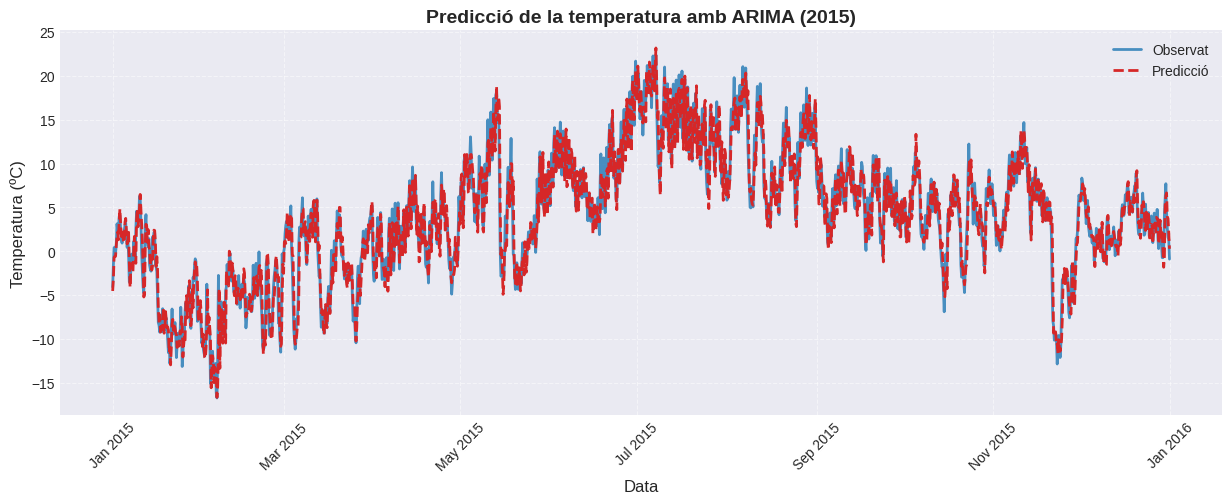

In [120]:
# Mateix plot pero ens fixem nomes en 2015

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-darkgrid")  # Millora l'estil del gràfic

fig, ax = plt.subplots(figsize=(15, 5))

# Gràfica de dades observades
ax.plot(data['valor']['2015'], label='Observat', color='#1f77b4', linewidth=2, alpha=0.8)

# Gràfica de la predicció
ax.plot(predicted_mean['2015'], label='Predicció', color='#d62728', linestyle='dashed', linewidth=2)

# Si tens intervals de confiança, afegeix una banda d’ombra
if 'conf_int' in locals():  # Comprova si tens intervals
    lower_bound = conf_int.loc['2015', 'lower valor']
    upper_bound = conf_int.loc['2015', 'upper valor']
    ax.fill_between(predicted_mean.index, lower_bound, upper_bound, color='red', alpha=0.2, label='Interval confiança')

# Format de la graella i de les dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format curt de mes i any
plt.xticks(rotation=45)

# Etiquetes i títol
plt.title('Predicció de la temperatura amb ARIMA (2015)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (ºC)', fontsize=12)

# Llegenda i grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [121]:
# Valorem el RMSE i MAE
# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(data['valor'], predicted_mean))
print('RMSE:', rmse)

# Calcula el MAE
mae = mean_absolute_error(data['valor'], predicted_mean)
print('MAE:', mae)

RMSE: 1.6755773074016072
MAE: 1.271846530213517
